# 🌦️ Self-Supervised Learning Workshop
## Learning Weather Patterns from E-OBS Data

Welcome to this hands-on workshop on self-supervised learning for climate data! 

### 🎯 Learning Objectives
By the end of this workshop, you will:
- Understand self-supervised learning concepts
- Implement temporal prediction for weather forecasting
- Build masked modeling for data reconstruction
- Use PyTorch Lightning for clean ML code
- Visualize and evaluate model performance

### 🧠 What is Self-Supervised Learning?
Self-supervised learning allows models to learn from data without manual labels by creating learning tasks from the data itself:

1. **Temporal Prediction**: "Given 7 days of weather, predict tomorrow"
2. **Masked Modeling**: "Fill in missing parts of weather maps"

### 📊 Dataset: E-OBS Precipitation
- **Source**: European daily precipitation observations
- **Coverage**: 1950-2023, 0.25° grid resolution
- **Task**: Learn spatial and temporal patterns

Let's dive in! 🚀


## ⚙️ Setup and Configuration

### 🎯 **Workshop Configuration**:
- **Dataset size**: 1K training + 250 validation samples
- **Training time**: ~10-15 minutes total for both models
- **Batch size**: 8 (efficient for workshop demonstrations)
- **Epochs**: Optimized for quick demonstration

### 💡 **Workshop Focus**:
- **Speed**: Get results quickly to understand concepts
- **Learning**: Focus on understanding self-supervised learning principles
- **Practical**: Hands-on experience with real climate data

**Note**: In real projects, you'd use larger datasets and longer training!


In [1]:
# 🚀 Workshop Setup
import warnings
warnings.filterwarnings('ignore')  # Hide unnecessary warnings for cleaner output

# Essential imports
import torch
import sys
import os
sys.path.append('../src')

# Check device availability
def get_device_info():
    """Get information about available compute devices"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"🎮 GPU: {torch.cuda.get_device_name()}")
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        print("🍎 Apple Silicon GPU (MPS) available")
    else:
        device = torch.device('cpu')
        print("💻 Using CPU")
    
    return device

print("🌍 Welcome to the Self-Supervised Learning Workshop!")
print(f"PyTorch version: {torch.__version__}")
device = get_device_info()
print(f"Selected device: {device}")
print("\n✅ Setup complete - let's start learning!")


🌍 Welcome to the Self-Supervised Learning Workshop!
PyTorch version: 2.7.1
🍎 Apple Silicon GPU (MPS) available
Selected device: mps

✅ Setup complete - let's start learning!


## 🎓 Workshop Learning Path

We'll explore two fundamental self-supervised learning approaches:

### 1️⃣ **Temporal Prediction**
- **Goal**: Predict tomorrow's weather from past 7 days
- **Learning**: Temporal patterns and sequences
- **Applications**: Weather forecasting, time series prediction

### 2️⃣ **Masked Modeling**
- **Goal**: Reconstruct missing parts of weather maps
- **Learning**: Spatial relationships and patterns
- **Applications**: Data imputation, anomaly detection

### 🏗️ **Technical Architecture**
- **Framework**: PyTorch Lightning for clean code
- **Models**: Lightweight ConvLSTM and U-Net architectures
- **Training**: Fast iterations with early stopping
- **Evaluation**: Visual results + quantitative metrics

### 🎯 **Workshop Flow**
1. Load and explore the precipitation data
2. Build temporal prediction pipeline
3. Train and evaluate temporal model
4. Build masked modeling pipeline
5. Train and evaluate masked model
6. Compare results and discuss applications

Ready to start? Let's load our data! 📊


In [2]:
# 📚 Import Essential Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as L
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# 🔧 Import Custom Modules
from data_utils import (
    EOBSDataLoader,
    EOBSTemporalPredictionDataset,
    EOBSMaskedModelingDataset,
    get_device,
)
from models import (
    TemporalPredictionModel,
    MaskedModelingModel,
    TemporalPredictionLightningModule,
    MaskedModelingLightningModule,
)

# 🎯 Display Setup Information
print("🌍 E-OBS Self-Supervised Learning Workshop")
print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {L.__version__}")

# 🖥️ Setup Device
device = get_device()
print(f"Selected device: {device}")

# 📊 Configure Matplotlib for Better Plots
plt.style.use("default")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 10

print("\n✅ All libraries loaded successfully!")

🌍 E-OBS Self-Supervised Learning Workshop
PyTorch version: 2.7.1
PyTorch Lightning version: 2.5.2
🍎 Using Apple Metal Performance Shaders (MPS)
Selected device: mps

✅ All libraries loaded successfully!


## 1. 📊 Load and Explore E-OBS Precipitation Data

Let's start by loading our climate dataset! The E-OBS dataset contains daily precipitation measurements across Europe from 1950 to 2023.

### 🌍 About the E-OBS Dataset
- **Coverage**: All of Europe on a 0.25° grid
- **Time span**: 1950-2023 (27,000+ days)
- **Variables**: Precipitation (mm/day)
- **Resolution**: ~25km spatial resolution

**Fun fact**: This dataset contains over 2.5 billion data points! 🤯


In [3]:
# 🌍 Load E-OBS Climate Data
print("🔄 Loading E-OBS precipitation data ...")
eobs_loader = EOBSDataLoader(data_dir="../src/data")

print("📊 Loading precipitation data...")
eobs_data = {}
try:
    # Load precipitation mean data
    eobs_data['precipitation_mean'] = eobs_loader.load_precipitation_data()
    print("✅ Precipitation data loaded successfully!")
except:
    # Fallback to full loading if specific method doesn't exist
    eobs_data = eobs_loader.load_all_data()
    print("✅ Data loaded successfully (fallback method)!")

# 📊 Extract and Examine Precipitation Data
if 'precipitation_mean' in eobs_data:
    precip_data = eobs_data['precipitation_mean']
    
    # DEBUG: Check what type of data we have
    print(f"🔍 Data type: {type(precip_data)}")
    if isinstance(precip_data, dict):
        print(f"🔍 Dictionary keys: {list(precip_data.keys())}")
        
        # Handle nested dictionary structure
        if 'precipitation_mean' in precip_data:
            # It's a nested dictionary, get the actual precipitation data
            precip_data = precip_data['precipitation_mean']
            print(f"🔧 Extracted nested 'precipitation_mean' data")
        elif 'rr' in precip_data:
            precip_data = precip_data['rr']  # Extract the actual dataset
            print(f"🔧 Extracted 'rr' data")
        elif len(precip_data) == 1:
            precip_data = list(precip_data.values())[0]  # Get the single dataset
            print(f"🔧 Extracted single dataset")
        else:
            # Try each key to find the actual dataset
            for key, value in precip_data.items():
                if hasattr(value, 'rr') or hasattr(value, 'shape'):
                    precip_data = value
                    print(f"🔧 Found dataset under key: '{key}'")
                    break
            else:
                print("❌ Could not find dataset in nested structure")
                print(f"Available keys and their types:")
                for k, v in precip_data.items():
                    print(f"   - {k}: {type(v)}")
    
    # Check if we now have a valid dataset
    print(f"🔍 Final data type: {type(precip_data)}")
    
    # Now try to access the data
    print(f"\n📊 Dataset Overview:")
    if hasattr(precip_data, 'rr'):
        print(f"   - Shape: {precip_data.rr.shape}")
        print(f"   - Time range: {str(precip_data.time.min().values)[:10]} to {str(precip_data.time.max().values)[:10]}")
        print(f"   - Spatial coverage: {precip_data.latitude.min().values:.1f}°N to {precip_data.latitude.max().values:.1f}°N")
        print(f"   - Longitude range: {precip_data.longitude.min().values:.1f}°E to {precip_data.longitude.max().values:.1f}°E")
        print(f"   - Data range: {precip_data.rr.min().values:.3f} to {precip_data.rr.max().values:.1f} mm/day")
    elif hasattr(precip_data, 'shape'):
        # If it's the data array directly
        print(f"   - Shape: {precip_data.shape}")
        print(f"   - Time range: {str(precip_data.time.min().values)[:10]} to {str(precip_data.time.max().values)[:10]}")
        print(f"   - Spatial coverage: {precip_data.latitude.min().values:.1f}°N to {precip_data.latitude.max().values:.1f}°N")
        print(f"   - Longitude range: {precip_data.longitude.min().values:.1f}°E to {precip_data.longitude.max().values:.1f}°E")
        print(f"   - Data range: {precip_data.min().values:.3f} to {precip_data.max().values:.1f} mm/day")
    else:
        print(f"❌ Cannot access data. Type: {type(precip_data)}")
        if hasattr(precip_data, 'keys'):
            print(f"Available keys: {list(precip_data.keys())}")
        else:
            print(f"Available attributes: {[attr for attr in dir(precip_data) if not attr.startswith('_')][:10]}...")
    
    del eobs_data
else:
    print("❌ Precipitation data not found. Please check data files.")


🔄 Loading E-OBS precipitation data ...
📊 Initializing EOBSDataLoader with data directory: ../src/data
📊 Loading precipitation data...
📊 Loading precipitation_mean data from ../src/data/rr_ens_mean_0.25deg_reg_v31.0e.nc
   - Shape: FrozenMappingWarningOnValuesAccess({'time': 27394, 'longitude': 464, 'latitude': 201})
   - Variables: ['rr']
📊 Loading precipitation_spread data from ../src/data/rr_ens_spread_0.25deg_reg_v31.0e.nc
   - Shape: FrozenMappingWarningOnValuesAccess({'time': 27394, 'longitude': 464, 'latitude': 201})
   - Variables: ['rr']
✅ Precipitation data loaded successfully!
🔍 Data type: <class 'dict'>
🔍 Dictionary keys: ['precipitation_mean', 'precipitation_spread']
🔧 Extracted nested 'precipitation_mean' data
🔍 Final data type: <class 'xarray.core.dataset.Dataset'>

📊 Dataset Overview:
   - Shape: (27394, 201, 464)
   - Time range: 1950-01-01 to 2024-12-31
   - Spatial coverage: 25.4°N to 75.4°N
   - Longitude range: -40.4°E to 75.4°E
   - Data range: 0.000 to 229.9 mm/da

## 2. 🎨 Visualize Sample Data

Let's explore the precipitation patterns across Europe! Understanding your data is the first step in any ML project.

### 🤔 What should we look for?
- **Spatial patterns**: Where does it rain most?
- **Seasonal variations**: Different weather patterns
- **Extreme events**: Heavy precipitation days


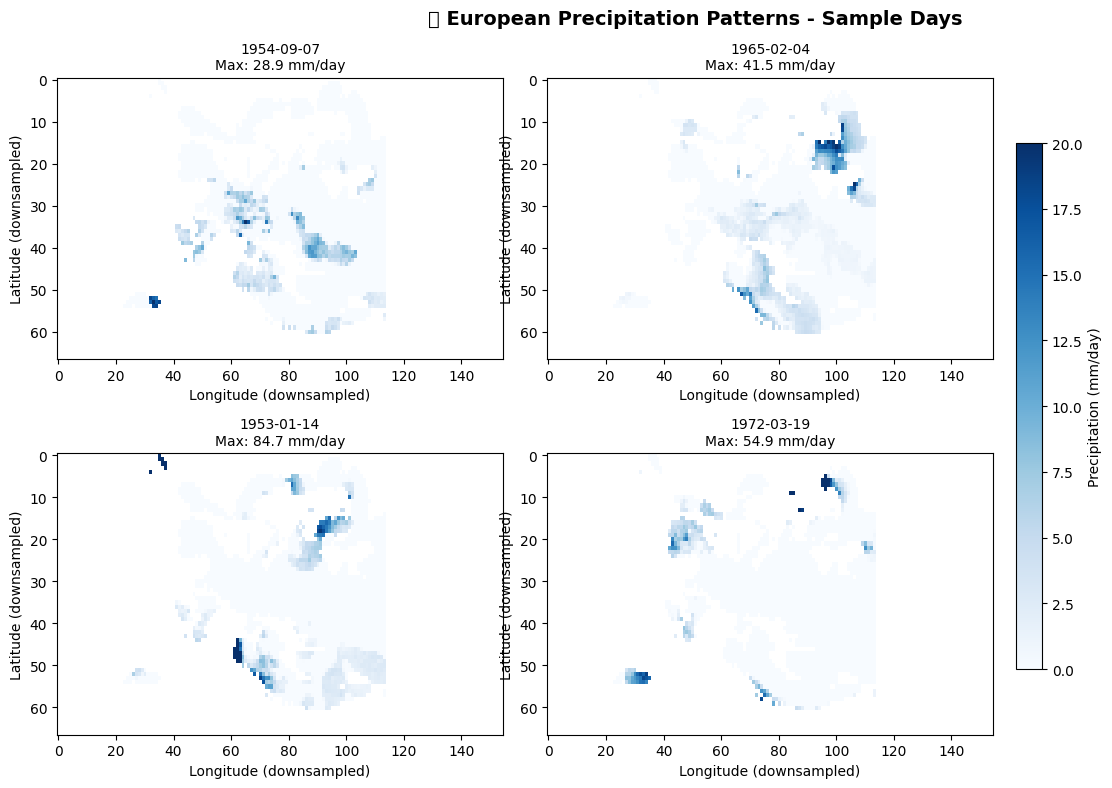

💡 Observations:
   - Notice the different precipitation patterns across Europe
   - Some days are dry (blue), others show heavy rain (dark blue)
   - Patterns often follow geographical features (mountains, coasts)
   - Visualization uses downsampled data for memory efficiency


In [4]:
# 🎨 Create Visualization of Precipitation Patterns
if 'precip_data' in locals():
    # MEMORY OPTIMIZATION: Use smaller figure size and fewer subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))  # Increased width for colorbar
    fig.suptitle('🌦️ European Precipitation Patterns - Sample Days', fontsize=14, fontweight='bold')
    
    # Select 4 interesting time indices (fewer than before)
    np.random.seed(42)  # For reproducible results
    time_indices = np.random.choice(len(precip_data.time), 4, replace=False)
    
    for i, time_idx in enumerate(time_indices):
        row, col = i // 2, i % 2
        ax = axes[row, col]
        
        # Get data for this time step
        data_slice = precip_data.isel(time=time_idx)
        
        # MEMORY OPTIMIZATION: Use downsampled data for visualization
        # Sample every 3rd point to reduce memory usage
        # Handle different data structures
        if hasattr(data_slice, 'rr'):
            downsampled_data = data_slice.rr[::3, ::3]
            max_precip = data_slice.rr.max().values
        else:
            # If it's the data array directly
            downsampled_data = data_slice[::3, ::3]
            max_precip = data_slice.max().values
        
        # Create plot with reduced resolution
        im = ax.imshow(downsampled_data, cmap='Blues', vmin=0, vmax=20, 
                      aspect='auto', interpolation='nearest')
        
        # Add informative title
        date_str = str(data_slice.time.values)[:10]
        ax.set_title(f'{date_str}\nMax: {max_precip:.1f} mm/day', fontsize=10)
        ax.set_xlabel('Longitude (downsampled)')
        ax.set_ylabel('Latitude (downsampled)')
    
    # Adjust layout to prevent colorbar overlap
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    
    # Add a colorbar for all subplots - positioned to avoid overlap
    cbar = plt.colorbar(im, ax=axes, 
                       pad=0.02, shrink=0.8, location='right')
    cbar.set_label('Precipitation (mm/day)', fontsize=10)
    
    plt.show()
    
    # MEMORY OPTIMIZATION: Clear visualization variables
    del fig, axes, im, data_slice, downsampled_data
    
    print("💡 Observations:")
    print("   - Notice the different precipitation patterns across Europe")
    print("   - Some days are dry (blue), others show heavy rain (dark blue)")
    print("   - Patterns often follow geographical features (mountains, coasts)")
    print("   - Visualization uses downsampled data for memory efficiency")
    
else:
    print("❌ No precipitation data to visualize")


## 3. 🔮 Temporal Prediction: Forecasting Tomorrow's Weather

Now let's build our first self-supervised model! This approach learns to predict tomorrow's precipitation using the past 3 days of data.

### 🤖 How it works:
1. **Input**: 3 consecutive days of precipitation maps
2. **Output**: Precipitation map for day 4 (tomorrow)
3. **Learning**: The model discovers temporal patterns without any labels!

### 🎯 Why is this useful?
- **Weather forecasting**: Predict future precipitation
- **Pattern recognition**: Learn seasonal and weather cycles
- **Feature extraction**: Create representations for other tasks

Let's build the dataset! 🚀


In [5]:
# 🏗️ Create Temporal Prediction Dataset 
if 'precip_data' in locals():
    print("🔄 Creating temporal prediction dataset...")
    
    print("📊 Cleaning precipitation data...")
    # Handle different data structures
    if hasattr(precip_data, 'rr'):
        precip_data.rr.values = np.nan_to_num(precip_data.rr.values, nan=0.0)
        variable_name = 'rr'
    else:
        # If it's the data array directly
        precip_data.values = np.nan_to_num(precip_data.values, nan=0.0)
        variable_name = precip_data.name if hasattr(precip_data, 'name') else 'data'
    
    # Create the temporal prediction dataset
    temporal_dataset = EOBSTemporalPredictionDataset(
        precipitation_data=precip_data,
        sequence_length=3,        # 3 days input
        prediction_horizon=1,     # Predict next 1 day
        variable_name=variable_name,
        spatial_crop_size=(32, 32),  # 32x32 spatial resolution
        normalize=True,
        log_transform=True
    )
    
    # Split dataset for training and validation
    train_size = int(0.8 * len(temporal_dataset))
    val_size = len(temporal_dataset) - train_size
    
    # Create workshop-sized subsets
    workshop_train_size = min(train_size, 1000)
    workshop_val_size = min(val_size, 250)
    
    # Create data splits
    train_dataset, val_dataset = torch.utils.data.random_split(
        temporal_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    # Create workshop-sized subsets
    workshop_train_dataset = torch.utils.data.Subset(train_dataset, range(workshop_train_size))
    workshop_val_dataset = torch.utils.data.Subset(val_dataset, range(workshop_val_size))
    
    # Create data loaders
    train_loader = DataLoader(workshop_train_dataset, batch_size=8, shuffle=True, num_workers=0)
    val_loader = DataLoader(workshop_val_dataset, batch_size=8, shuffle=False, num_workers=0)
    
    print(f"✅ Temporal dataset created!")
    print(f"   📊 Total sequences available: {len(temporal_dataset):,}")
    print(f"   🚀 Workshop training samples: {len(workshop_train_dataset):,}")
    print(f"   ✅ Workshop validation samples: {len(workshop_val_dataset):,}")
    print(f"   🎯 Input: 3 days × 32×32 pixels")
    print(f"   🎯 Output: 1 day × 32×32 pixels")
    print(f"   💾 Batch size: 8")
    
    # Clear temporary variables
    del train_dataset, val_dataset
    
else:
    print("❌ Cannot create temporal dataset without precipitation data")


🔄 Creating temporal prediction dataset...
📊 Cleaning precipitation data...
📊 Calculating normalization statistics...
   - Mean: 0.1415
   - Std: 0.5015
📊 Temporal Dataset created:
   - Sequence length: 3
   - Prediction horizon: 1
   - Spatial crop size: (32, 32)
   - Total samples: 27391
   - Original spatial dims: (201, 464)
   - Normalize: True
   - Log transform: True
✅ Temporal dataset created!
   📊 Total sequences available: 27,391
   🚀 Workshop training samples: 1,000
   ✅ Workshop validation samples: 250
   🎯 Input: 3 days × 32×32 pixels
   🎯 Output: 1 day × 32×32 pixels
   💾 Batch size: 8


📊 Let's examine a sample from our temporal dataset...
✅ Sample batch loaded:
   🔢 Input shape: torch.Size([8, 3, 1, 32, 32])  # (batch_size, sequence_days, height, width)
   🔢 Target shape: torch.Size([8, 1, 1, 32, 32])  # (batch_size, prediction_days, height, width)


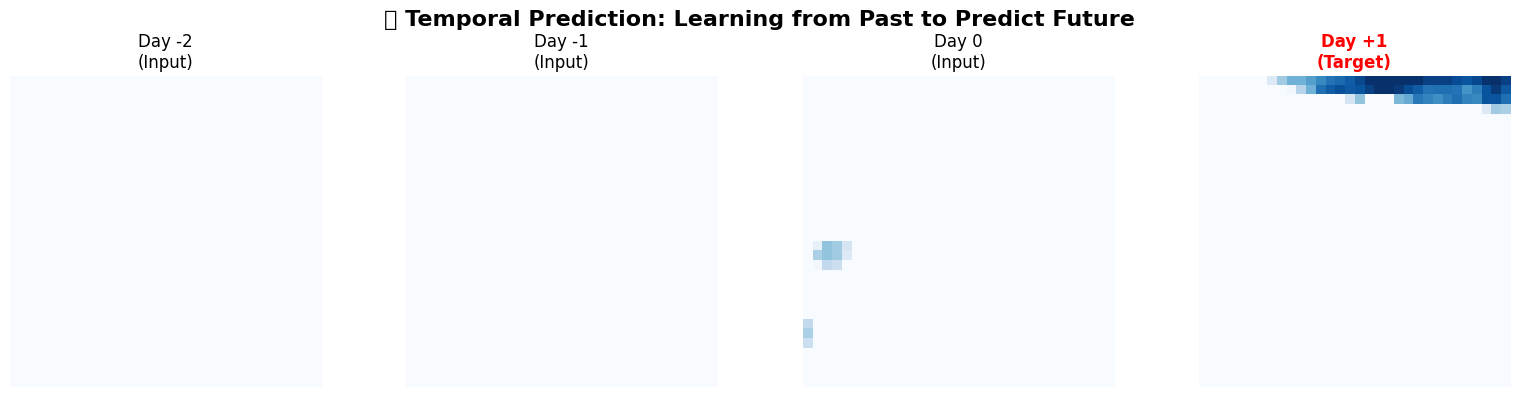

🎯 Understanding the Task:
   - Model sees 3 consecutive days of precipitation
   - Goal: Predict the precipitation pattern for day 4
   - This is like teaching the model to be a weather forecaster!


In [6]:
# 🔍 Explore the Temporal Dataset
if 'precip_data' in locals():
    print("📊 Let's examine a sample from our temporal dataset...")
    
    # Get a sample batch
    sample_batch = next(iter(train_loader))
    inputs, targets = sample_batch
    
    print(f"✅ Sample batch loaded:")
    print(f"   🔢 Input shape: {inputs.shape}  # (batch_size, sequence_days, height, width)")
    print(f"   🔢 Target shape: {targets.shape}  # (batch_size, prediction_days, height, width)")
    
    # Visualize a sample sequence
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    fig.suptitle('🔮 Temporal Prediction: Learning from Past to Predict Future', fontsize=16, fontweight='bold')
    
    sample_idx = 0
    input_seq = inputs[sample_idx]  # (3, 32, 32)
    target_day = targets[sample_idx, 0]  # (32, 32)
    
    # Plot input sequence (3 days)
    for i in range(3):
        ax = axes[i]
        im = ax.imshow(input_seq[i].squeeze(), cmap='Blues', vmin=0, vmax=3)
        ax.set_title(f'Day {i-2}\n(Input)', fontsize=12)
        ax.axis('off')
    
    # Plot target (prediction day)
    ax = axes[3]
    im = ax.imshow(target_day.squeeze(), cmap='Blues', vmin=0, vmax=3)
    ax.set_title('Day +1\n(Target)', fontweight='bold', color='red', fontsize=12)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("🎯 Understanding the Task:")
    print("   - Model sees 3 consecutive days of precipitation")
    print("   - Goal: Predict the precipitation pattern for day 4")
    print("   - This is like teaching the model to be a weather forecaster!")


In [7]:
# 🚀 Train Temporal Prediction Model
if 'precip_data' in locals():
    print("🤖 Building our temporal prediction model...")
    
    # Create temporal prediction model
    temporal_model = TemporalPredictionModel(
        input_channels=1,        # Single channel (precipitation)
        hidden_channels=8,       
        num_layers=4,           
        sequence_length=3,       # number of past/input days
        prediction_horizon=1,    # Predict 1 day ahead
        spatial_size=(32, 32)    
    )
    
    # Wrap in PyTorch Lightning for clean training
    temporal_lightning_model = TemporalPredictionLightningModule(
        model=temporal_model,
        learning_rate=2e-3,
        weight_decay=1e-4
    )
    
    # Setup training callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            mode='min'
        ),
        ModelCheckpoint(
            monitor='val_loss',
            dirpath='../src/runs/temporal_prediction_lightning/',
            filename='best-checkpoint',
            save_top_k=1,
            mode='min'
        )
    ]
    
    # Create the trainer
    temporal_trainer = L.Trainer(
        max_epochs=6,
        callbacks=callbacks,
        log_every_n_steps=10,
        precision='16-mixed',    
        enable_checkpointing=True,
        enable_progress_bar=True,
        enable_model_summary=False,
        accelerator='auto',
        devices='auto'
    )
    
    print("🎯 Training Configuration:")
    print(f"   - Model: ConvLSTM with {sum(p.numel() for p in temporal_model.parameters()):,} parameters")
    print(f"   - Training samples: {len(workshop_train_dataset):,}")
    print(f"   - Max epochs: 6 (with early stopping)")
    print(f"   - Sequence length: 3 days")
    print(f"   - Learning rate: 2e-3")
    print(f"   - Precision: 16-bit mixed precision")
    print(f"   - Spatial size: 32x32 (reduced for speed)")
    
    # Start training!
    print("\n🚀 Starting temporal prediction training...")
    print("⚡ This should take about 2-3 minutes!")
    
    temporal_trainer.fit(
        temporal_lightning_model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader
    )
    
    print(f"\n🎉 Training completed successfully!")
    print(f"   ✅ Best validation loss: {temporal_trainer.checkpoint_callback.best_model_score:.6f}")
    print(f"   📁 Model saved at: {temporal_trainer.checkpoint_callback.best_model_path}")
    
    # Save the best model path before deleting trainer
    best_model_path_temporal = temporal_trainer.checkpoint_callback.best_model_path
    
    # MEMORY OPTIMIZATION: Clear training variables
    del temporal_trainer
    torch.cuda.empty_cache()  # Clear GPU memory if available
    
    
else:
    print("❌ Cannot train temporal model without precipitation data")


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


🤖 Building our temporal prediction model...
🎯 Training Configuration:
   - Model: ConvLSTM with 4,728 parameters
   - Training samples: 1,000
   - Max epochs: 6 (with early stopping)
   - Sequence length: 3 days
   - Learning rate: 2e-3
   - Precision: 16-bit mixed precision
   - Spatial size: 32x32 (reduced for speed)

🚀 Starting temporal prediction training...
⚡ This should take about 2-3 minutes!


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


🎉 Training completed successfully!
   ✅ Best validation loss: 0.628824
   📁 Model saved at: /Users/leopinetzki/Library/Mobile Documents/com~apple~CloudDocs/data/Studium/BLISS/hydrology_seminar/src/runs/temporal_prediction_lightning/best-checkpoint-v2.ckpt


In [8]:
# 💾 Save Our Trained Model
print("💾 Saving the trained temporal prediction model...")

# Create models directory if it doesn't exist
import os
os.makedirs('../src/models', exist_ok=True)

# Save the best model using the saved path
if 'best_model_path_temporal' in locals() and best_model_path_temporal:
    # Load and save the best model
    best_model = TemporalPredictionLightningModule.load_from_checkpoint(
        best_model_path_temporal,
        model=temporal_model
    )
    
    # Save for future use
    torch.save(
        best_model.model.state_dict(),
        '../src/models/temporal_prediction_model.pth'
    )
    
    print(f"✅ Model saved successfully!")
    print(f"   📁 Location: ../src/models/temporal_prediction_model.pth")
    print(f"   💡 You can load this model later for inference!")
else:
    print("❌ No checkpoint found to save or temporal trainer not available")

💾 Saving the trained temporal prediction model...
✅ Model saved successfully!
   📁 Location: ../src/models/temporal_prediction_model.pth
   💡 You can load this model later for inference!


## 4. 🎭 Masked Modeling: Filling in Missing Pieces

Now let's build our second self-supervised model! This approach learns to reconstruct missing parts of precipitation maps.

### 🧩 How it works:
1. **Input**: Precipitation map with random patches masked out
2. **Output**: Complete precipitation map (original)
3. **Learning**: The model learns spatial relationships and patterns

### 🎯 Why is this useful?
- **Data imputation**: Fill missing data in weather observations
- **Anomaly detection**: Identify unusual patterns
- **Data compression**: Learn compact representations
- **Quality control**: Detect sensor errors

This is like teaching the model to be a "weather detective" - filling in missing clues! 🔍


In [9]:
# 🏗️ Create Masked Modeling Dataset
if 'precip_data' in locals():
    print("🔄 Creating masked modeling dataset...")
    
    if hasattr(precip_data, 'rr'):
        variable_name = 'rr'
    else:
        variable_name = precip_data.name if hasattr(precip_data, 'name') else 'data'
    
    # Create the masked modeling dataset with reduced memory footprint
    masked_dataset = EOBSMaskedModelingDataset(
        precipitation_data=precip_data,
        variable_name=variable_name,
        spatial_size=(48, 48),  
        mask_ratio=0.25,           # Mask 25% of each image
        mask_strategy='random_patches',  # Use random patch masking
        patch_size=6,             
        normalize=True,
        log_transform=True,
        temporal_context=1         # Single time step
    )
    
    # Split dataset for training and validation
    train_size = int(0.8 * len(masked_dataset))
    val_size = len(masked_dataset) - train_size
    
    # MEMORY OPTIMIZATION: Use even smaller datasets
    workshop_train_size_masked = min(train_size, 1000)  # Reduced from 2000 to 1000
    workshop_val_size_masked = min(val_size, 250)       # Reduced from 500 to 250
    
    # Create data splits
    train_dataset_masked, val_dataset_masked = torch.utils.data.random_split(
        masked_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    # Create workshop-sized subsets
    workshop_train_dataset_masked = torch.utils.data.Subset(train_dataset_masked, range(workshop_train_size_masked))
    workshop_val_dataset_masked = torch.utils.data.Subset(val_dataset_masked, range(workshop_val_size_masked))
    
    # MEMORY OPTIMIZATION: Reduce batch size for better memory management
    train_loader_masked = DataLoader(workshop_train_dataset_masked, batch_size=8, shuffle=True, num_workers=0)
    val_loader_masked = DataLoader(workshop_val_dataset_masked, batch_size=8, shuffle=False, num_workers=0)
    
    print(f"✅ Masked modeling dataset created!")
    print(f"   📊 Total samples available: {len(masked_dataset):,}")
    print(f"   🚀 Workshop training samples: {len(workshop_train_dataset_masked):,}")
    print(f"   ✅ Workshop validation samples: {len(workshop_val_dataset_masked):,}")
    print(f"   🎯 Task: Reconstruct 25% masked areas")
    print(f"   🧩 Patch size: 6×6 pixels")
    print(f"   💾 Batch size: 8")
    
    # MEMORY OPTIMIZATION: Clear temporary variables
    del train_dataset_masked, val_dataset_masked
    
    
else:
    print("❌ Cannot create masked dataset without precipitation data")


🔄 Creating masked modeling dataset...
📊 Calculating normalization statistics...
   - Mean: 0.1512
   - Std: 0.5065
🎭 Masked Modeling Dataset created:
   - Spatial size: (48, 48)
   - Mask ratio: 0.25
   - Mask strategy: random_patches
   - Patch size: 6
   - Total samples: 27394
   - Original spatial dims: (201, 464)
   - Normalize: True
   - Log transform: True
✅ Masked modeling dataset created!
   📊 Total samples available: 27,394
   🚀 Workshop training samples: 1,000
   ✅ Workshop validation samples: 250
   🎯 Task: Reconstruct 25% masked areas
   🧩 Patch size: 6×6 pixels
   💾 Batch size: 8


📊 Let's examine a sample from our masked modeling dataset...
✅ Sample batch loaded:
   🔢 Masked input shape: torch.Size([8, 1, 48, 48])
   🔢 Target shape: torch.Size([8, 1, 48, 48])
   🔢 Mask shape: torch.Size([8, 48, 48])


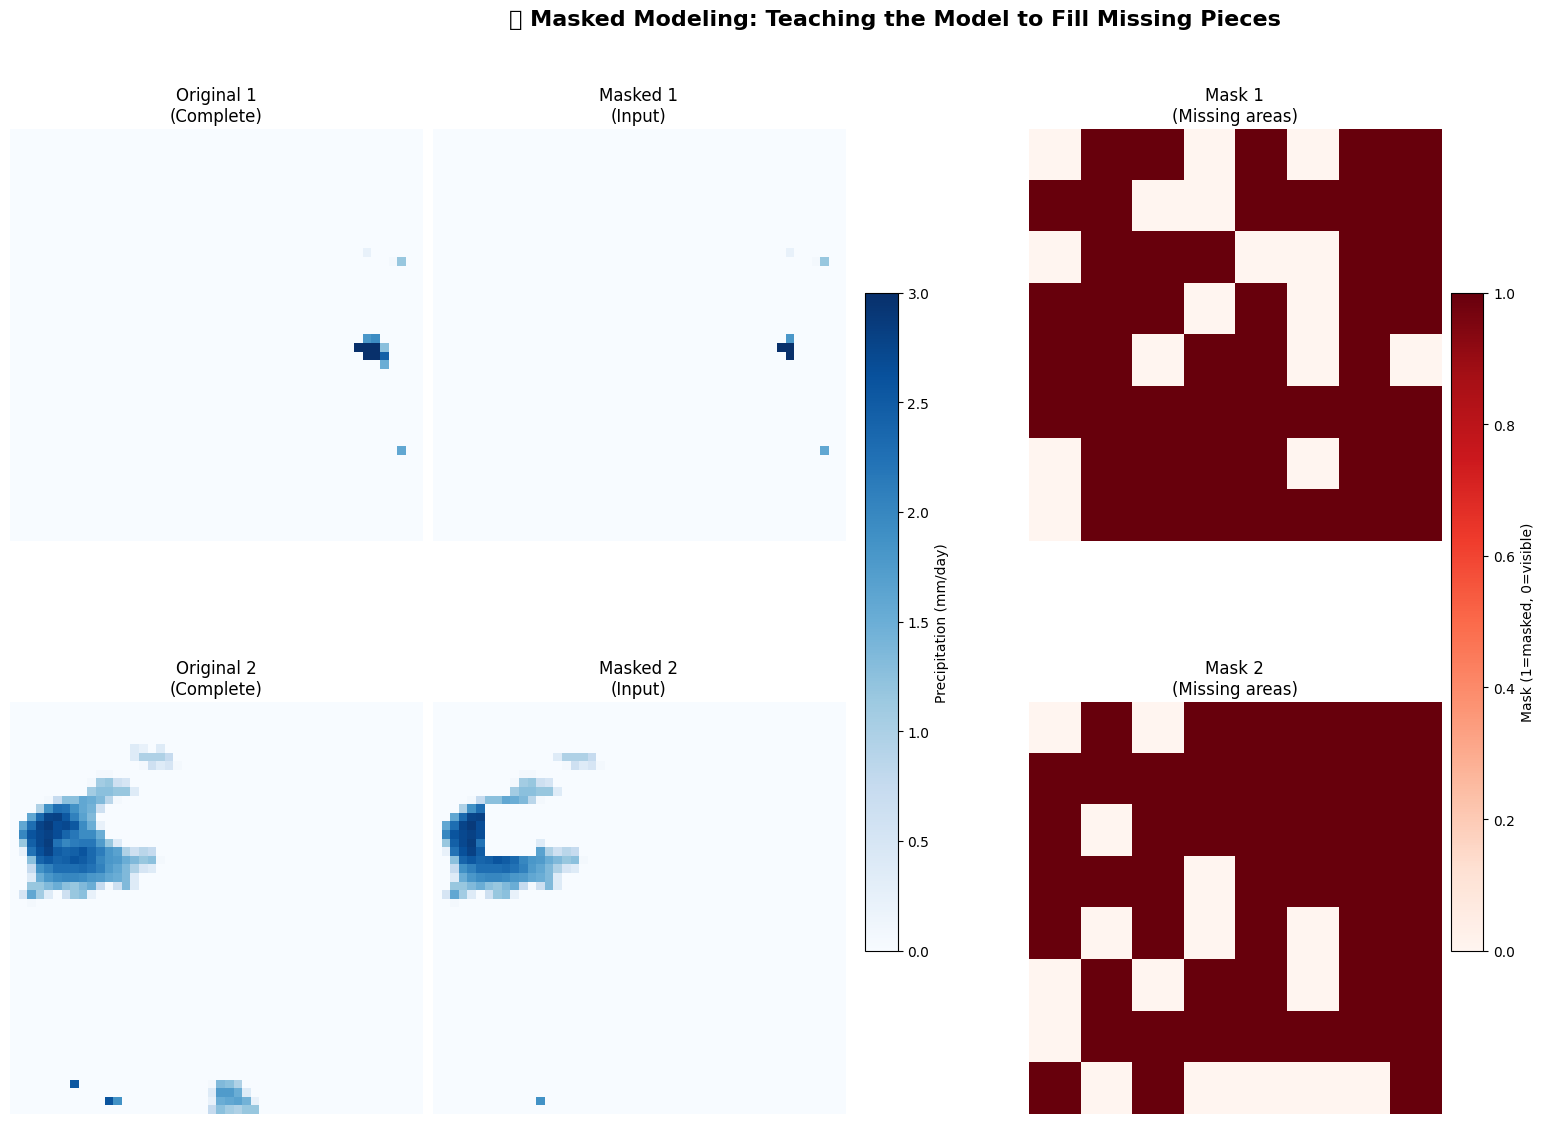


🎯 Understanding the Task:
   - Model sees precipitation maps with missing patches (black areas)
   - Goal: Reconstruct the complete precipitation pattern
   - Red areas in mask show which regions need to be filled
   - Average mask ratio: 75.0% (1728 pixels)
   - This teaches the model spatial relationships in weather data!


In [10]:
# 🔍 Explore the Masked Modeling Dataset
if 'precip_data' in locals():
    print("📊 Let's examine a sample from our masked modeling dataset...")
    
    # Get a sample batch
    sample_batch_masked = next(iter(train_loader_masked))
    masked_inputs, targets, masks = sample_batch_masked
    
    print(f"✅ Sample batch loaded:")
    print(f"   🔢 Masked input shape: {masked_inputs.shape}")
    print(f"   🔢 Target shape: {targets.shape}")
    print(f"   🔢 Mask shape: {masks.shape}")
    
    # Visualize the masking process
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🎭 Masked Modeling: Teaching the Model to Fill Missing Pieces', fontsize=16, fontweight='bold')
    
    # Store the image mappables for colorbars
    im_precip = None
    im_mask = None
    
    for i in range(2):
        # Original (complete precipitation map)
        ax = axes[i, 0]
        original = targets[i, 0]  # (H, W)
        im_precip = ax.imshow(original, cmap='Blues', vmin=0, vmax=3)
        ax.set_title(f'Original {i+1}\n(Complete)', fontsize=12)
        ax.axis('off')
        
        # Masked (input with missing patches)
        ax = axes[i, 1]
        masked = masked_inputs[i, 0]  # (H, W)
        im_precip = ax.imshow(masked, cmap='Blues', vmin=0, vmax=3)
        ax.set_title(f'Masked {i+1}\n(Input)', fontsize=12)
        ax.axis('off')
        
        # Mask (shows which areas are masked)
        ax = axes[i, 2]
        mask = masks[i]  # (H, W)
        im_mask = ax.imshow(mask, cmap='Reds', vmin=0, vmax=1)
        ax.set_title(f'Mask {i+1}\n(Missing areas)', fontsize=12)
        ax.axis('off')
    
    # Adjust layout to prevent colorbar overlap
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    
    # Add colorbars for precipitation and mask data
    if im_precip is not None:
        cbar_precip = plt.colorbar(im_precip, ax=axes[:, :2], 
                                  pad=0.02, shrink=0.6, location='right')
        cbar_precip.set_label('Precipitation (mm/day)', fontsize=10)
    
    if im_mask is not None:
        cbar_mask = plt.colorbar(im_mask, ax=axes[:, 2], 
                                pad=0.02, shrink=0.6, location='right')
        cbar_mask.set_label('Mask (1=masked, 0=visible)', fontsize=10)
    
    plt.show()
    
    # Print masking statistics
    mask_ratio = masks.float().mean()
    print(f"\n🎯 Understanding the Task:")
    print(f"   - Model sees precipitation maps with missing patches (black areas)")
    print(f"   - Goal: Reconstruct the complete precipitation pattern")
    print(f"   - Red areas in mask show which regions need to be filled")
    print(f"   - Average mask ratio: {mask_ratio:.1%} ({mask_ratio * 48 * 48:.0f} pixels)")
    print(f"   - This teaches the model spatial relationships in weather data!")


## 🚀 Train Masked Modeling Model

Now let's train our second model! This U-Net architecture will learn to reconstruct missing precipitation patterns.

### 🏗️ Model Architecture
- **U-Net**: Encoder-decoder with skip connections
- **Task**: Fill in missing 25% of precipitation data
- **Learning**: Spatial relationships and texture patterns


In [11]:
# 🤖 Build and Train Masked Modeling Model
if 'precip_data' in locals():
    print("🤖 Building our masked modeling model...")
    
    # Create masked modeling model
    masked_model = MaskedModelingModel(
        input_channels=1,      # Single channel (precipitation)
        base_channels=16,      # 16 base channels
        num_levels=2,          # 2 levels in U-Net
        temporal_context=1     # Single time step
    )
    
    # Wrap in PyTorch Lightning for clean training
    masked_lightning_model = MaskedModelingLightningModule(
        model=masked_model,
        learning_rate=1e-3,    # Stable learning rate
        weight_decay=1e-4
    )
    
    # Setup training callbacks
    callbacks_masked = [
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            verbose=True,
            mode='min'
        ),
        ModelCheckpoint(
            monitor='val_loss',
            dirpath='../src/runs/masked_modeling_lightning/',
            filename='best-checkpoint',
            save_top_k=1,
            mode='min'
        )
    ]
    
    # Create the trainer
    masked_trainer = L.Trainer(
        max_epochs=6,
        callbacks=callbacks_masked,
        log_every_n_steps=20,
        precision='16-mixed',
        gradient_clip_val=0.5,
        enable_checkpointing=True,
        enable_progress_bar=True,
        enable_model_summary=False,
        accelerator='auto',
        devices='auto'
    )
    
    print("🎯 Training Configuration:")
    print(f"   - Model: U-Net with {sum(p.numel() for p in masked_model.parameters()):,} parameters")
    print(f"   - Training samples: {len(workshop_train_dataset_masked):,}")
    print(f"   - Max epochs: 6 (with early stopping)")
    print(f"   - Learning rate: 1e-3")
    
    # Start training!
    print("\n🚀 Starting masked modeling training...")
    print("☕ This will take about 10-15 minutes. Time for another coffee!")
    
    masked_trainer.fit(
        masked_lightning_model,
        train_dataloaders=train_loader_masked,
        val_dataloaders=val_loader_masked
    )
    
    print(f"\n🎉 Training completed successfully!")
    print(f"   ✅ Best validation loss: {masked_trainer.checkpoint_callback.best_model_score:.6f}")
    print(f"   📁 Model saved at: {masked_trainer.checkpoint_callback.best_model_path}")
    
else:
    print("❌ Cannot train masked model without precipitation data")


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


🤖 Building our masked modeling model...
🎯 Training Configuration:
   - Model: U-Net with 25,649 parameters
   - Training samples: 1,000
   - Max epochs: 6 (with early stopping)
   - Learning rate: 1e-3

🚀 Starting masked modeling training...
☕ This will take about 10-15 minutes. Time for another coffee!


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.060


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.055


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.055. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=6` reached.



🎉 Training completed successfully!
   ✅ Best validation loss: 0.055049
   📁 Model saved at: /Users/leopinetzki/Library/Mobile Documents/com~apple~CloudDocs/data/Studium/BLISS/hydrology_seminar/src/runs/masked_modeling_lightning/best-checkpoint-v1.ckpt


🔮 Evaluating temporal prediction model...
✅ Temporal Prediction Results:
   📊 MSE: 0.811141
   📊 MAE: 0.403153


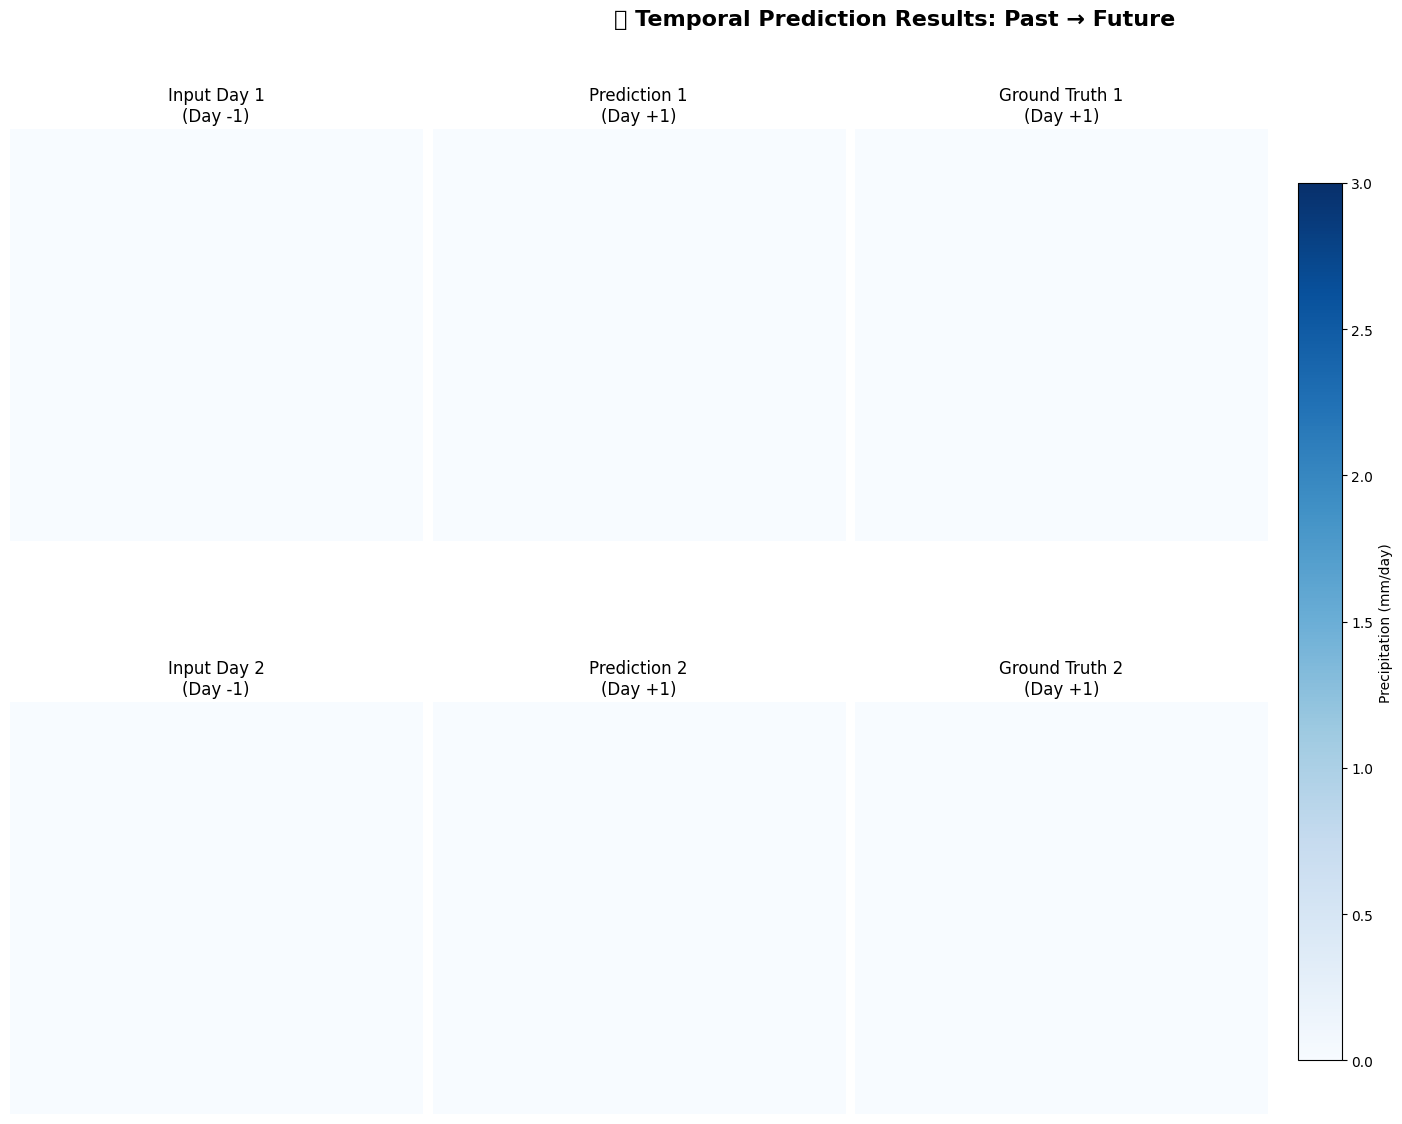

💡 Observations:
   - Model learns to predict general precipitation patterns
   - Spatial structure is preserved in predictions
   - Some details may be smoothed due to inherent prediction uncertainty


In [12]:
# 📊 Evaluate Temporal Prediction Model
print("🔮 Evaluating temporal prediction model...")

temporal_lightning_model.eval()

with torch.no_grad():
    # Get a validation batch
    val_batch = next(iter(val_loader))
    inputs, targets = val_batch
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    # Make predictions
    predictions = temporal_lightning_model(inputs)
    
    # Move to CPU for visualization
    predictions_cpu = predictions.cpu()
    inputs_cpu = inputs.cpu()
    targets_cpu = targets.cpu()
    
    # Calculate metrics
    mse = torch.nn.functional.mse_loss(predictions, targets)
    mae = torch.nn.functional.l1_loss(predictions, targets)
    
    print(f"✅ Temporal Prediction Results:")
    print(f"   📊 MSE: {mse:.6f}")
    print(f"   📊 MAE: {mae:.6f}")
    
    # Visualize predictions
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🔮 Temporal Prediction Results: Past → Future', fontsize=16, fontweight='bold')
    
    # Store the image mappable for colorbar
    im_precip = None
    
    for i in range(2):
        # Input (last day of sequence)
        ax = axes[i, 0]
        last_input = inputs_cpu[i, -1]  # Last day of input sequence
        im_precip = ax.imshow(last_input.squeeze(), cmap='Blues', vmin=0, vmax=3)
        ax.set_title(f'Input Day {i+1}\n(Day -1)', fontsize=12)
        ax.axis('off')
        
        # Prediction
        ax = axes[i, 1]
        pred = predictions_cpu[i, 0]  # First (only) prediction
        im_precip = ax.imshow(pred.squeeze(), cmap='Blues', vmin=0, vmax=3)
        ax.set_title(f'Prediction {i+1}\n(Day +1)', fontsize=12)
        ax.axis('off')
        
        # Ground truth
        ax = axes[i, 2]
        target = targets_cpu[i, 0]  # First (only) target
        im_precip = ax.imshow(target.squeeze(), cmap='Blues', vmin=0, vmax=3)
        ax.set_title(f'Ground Truth {i+1}\n(Day +1)', fontsize=12)
        ax.axis('off')
    
    # Adjust layout to prevent colorbar overlap
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    
    # Add colorbar for precipitation data
    if im_precip is not None:
        cbar = plt.colorbar(im_precip, ax=axes, 
                           pad=0.02, shrink=0.8, location='right')
        cbar.set_label('Precipitation (mm/day)', fontsize=10)
    
    plt.show()
    
    print("💡 Observations:")
    print("   - Model learns to predict general precipitation patterns")
    print("   - Spatial structure is preserved in predictions")
    print("   - Some details may be smoothed due to inherent prediction uncertainty")

🔮 Evaluating masked modeling reconstruction...
✅ Masked Modeling Results:
   📊 MSE (masked regions): 1.082113
   📊 MAE (masked regions): 0.246958
   📊 Masked pixels: 13824.0/18432 (75.00%)
💡 Observations:
   - Model learns to reconstruct masked regions
   - Spatial coherence is maintained in reconstructions
   - Model captures patterns from visible context


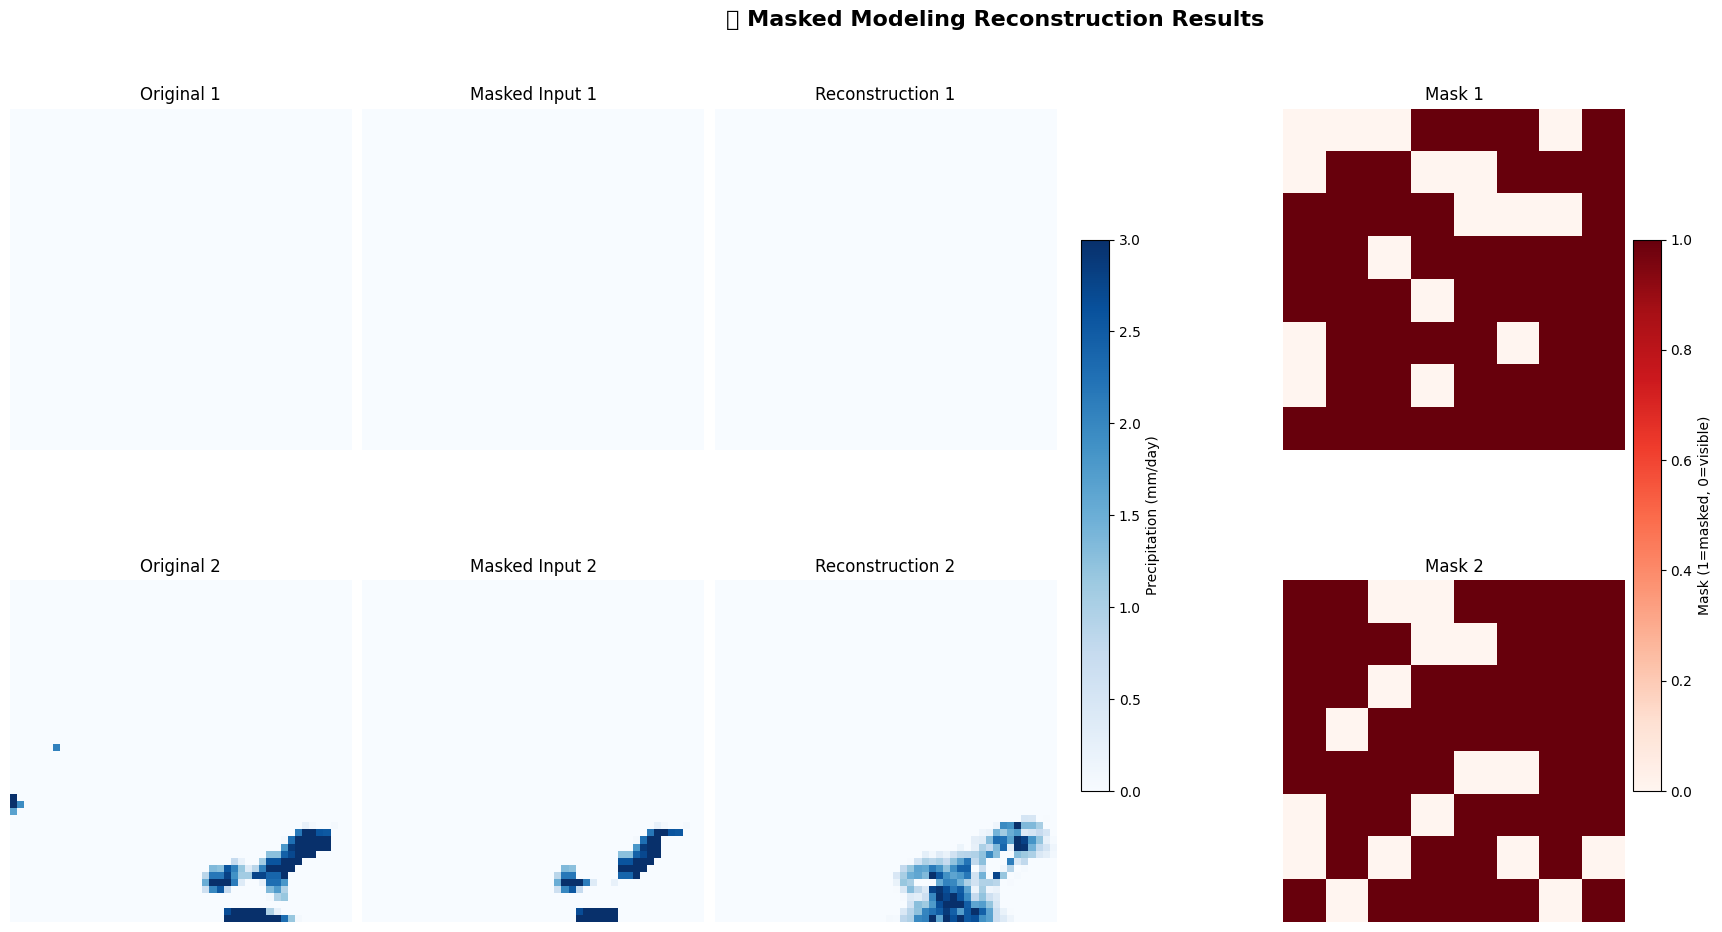

In [14]:
# 🎭 Evaluate Masked Modeling
print("🔮 Evaluating masked modeling reconstruction...")

masked_lightning_model.eval()
masked_lightning_model = masked_lightning_model.to(device)

with torch.no_grad():
    # Get a validation batch
    val_batch = next(iter(val_loader_masked))
    masked_inputs, targets, masks = val_batch
    masked_inputs = masked_inputs.to(device)
    targets = targets.to(device)
    
    # Make predictions
    predictions = masked_lightning_model(masked_inputs)
    
    # Move to CPU for visualization
    predictions_cpu = predictions.cpu()
    masked_inputs_cpu = masked_inputs.cpu()
    targets_cpu = targets.cpu()
    
    # Calculate metrics only on masked regions
    if masks.sum() > 0:
        # Expand mask to match predictions/targets shape [8, 1, 48, 48]
        mask_expanded = masks.bool().unsqueeze(1)  # [8, 48, 48] -> [8, 1, 48, 48]
        
        # Extract only the masked regions for computing metrics
        masked_predictions = predictions[mask_expanded]
        masked_targets = targets[mask_expanded]
        
        masked_mse = torch.nn.functional.mse_loss(masked_predictions, masked_targets)
        masked_mae = torch.nn.functional.l1_loss(masked_predictions, masked_targets)
        
        print(f"✅ Masked Modeling Results:")
        print(f"   📊 MSE (masked regions): {masked_mse:.6f}")
        print(f"   📊 MAE (masked regions): {masked_mae:.6f}")
        print(f"   📊 Masked pixels: {masks.sum()}/{masks.numel()} ({masks.float().mean():.2%})")
    
    # Visualize reconstructions
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('🎭 Masked Modeling Reconstruction Results', fontsize=16, fontweight='bold')
    
    # Store the image mappables for colorbars
    im_precip = None
    im_mask = None
    
    for i in range(2):
        # Original
        ax = axes[i, 0]
        original = targets_cpu[i, 0]
        im_precip = ax.imshow(original, cmap='Blues', vmin=0, vmax=3)
        ax.set_title(f'Original {i+1}', fontsize=12)
        ax.axis('off')
        
        # Masked input
        ax = axes[i, 1]
        masked_input = masked_inputs_cpu[i, 0]
        im_precip = ax.imshow(masked_input, cmap='Blues', vmin=0, vmax=3)
        ax.set_title(f'Masked Input {i+1}', fontsize=12)
        ax.axis('off')
        
        # Prediction
        ax = axes[i, 2]
        pred = predictions_cpu[i, 0]
        im_precip = ax.imshow(pred, cmap='Blues', vmin=0, vmax=3)
        ax.set_title(f'Reconstruction {i+1}', fontsize=12)
        ax.axis('off')
        
        # Mask visualization
        ax = axes[i, 3]
        mask_vis = masks[i]  # masks_cpu has shape [batch, height, width]
        im_mask = ax.imshow(mask_vis, cmap='Reds', vmin=0, vmax=1)
        ax.set_title(f'Mask {i+1}', fontsize=12)
        ax.axis('off')
    
    # Adjust layout to prevent colorbar overlap
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    
    # Add colorbars for precipitation and mask data
    if im_precip is not None:
        cbar_precip = plt.colorbar(im_precip, ax=axes[:, :3], 
                                  pad=0.02, shrink=0.6, location='right')
        cbar_precip.set_label('Precipitation (mm/day)', fontsize=10)
    
    if im_mask is not None:
        cbar_mask = plt.colorbar(im_mask, ax=axes[:, 3], 
                                pad=0.02, shrink=0.6, location='right')
        cbar_mask.set_label('Mask (1=masked, 0=visible)', fontsize=10)
    
    print("💡 Observations:")
    print("   - Model learns to reconstruct masked regions")
    print("   - Spatial coherence is maintained in reconstructions")
    print("   - Model captures patterns from visible context")

In [15]:
# 🏆 Compare Both Approaches
print("📊 Workshop Summary - Self-Supervised Learning Approaches")
print("="*60)

print("\n1. 🔮 Temporal Prediction:")
print("   ✅ Learns to predict future weather patterns")
print("   ✅ Captures temporal dynamics and trends")
print("   ✅ Useful for forecasting applications")
print("   💡 Best for: Time series prediction, weather forecasting")

print("\n2. 🎭 Masked Modeling:")
print("   ✅ Learns to reconstruct missing data")
print("   ✅ Captures spatial relationships and patterns")
print("   ✅ Robust to missing/corrupted data")
print("   💡 Best for: Data imputation, anomaly detection")

print("\n🎯 Key Takeaways:")
print("   • Both approaches learn useful representations WITHOUT labels")
print("   • Temporal prediction focuses on time-based patterns")
print("   • Masked modeling focuses on spatial relationships")
print("   • Both can be used for downstream tasks (classification, clustering)")
print("   • Self-supervised learning is powerful for unlabeled climate data")

print("\n🚀 Next Steps:")
print("   • Try different masking strategies (random, structured)")
print("   • Experiment with different temporal contexts")
print("   • Apply to other climate variables (temperature, humidity)")
print("   • Use learned representations for downstream tasks")

print("\n✅ Workshop Complete! You've successfully explored SSL with climate data!")


📊 Workshop Summary - Self-Supervised Learning Approaches

1. 🔮 Temporal Prediction:
   ✅ Learns to predict future weather patterns
   ✅ Captures temporal dynamics and trends
   ✅ Useful for forecasting applications
   💡 Best for: Time series prediction, weather forecasting

2. 🎭 Masked Modeling:
   ✅ Learns to reconstruct missing data
   ✅ Captures spatial relationships and patterns
   ✅ Robust to missing/corrupted data
   💡 Best for: Data imputation, anomaly detection

🎯 Key Takeaways:
   • Both approaches learn useful representations WITHOUT labels
   • Temporal prediction focuses on time-based patterns
   • Masked modeling focuses on spatial relationships
   • Both can be used for downstream tasks (classification, clustering)
   • Self-supervised learning is powerful for unlabeled climate data

🚀 Next Steps:
   • Try different masking strategies (random, structured)
   • Experiment with different temporal contexts
   • Apply to other climate variables (temperature, humidity)
   • Us

### Potential Improvements / Next Steps
1. **Extend to Multiple Variables**: Include temperature, pressure, humidity
2. **Multi-Scale Modeling**: Work with different spatial resolutions
3. **Physics-Informed Constraints**: Incorporate conservation laws
4. **Transfer Learning**: Fine-tune on specific regions or tasks
5. **Hyperparameter Tuning**: Use Lightning's built-in HPO tools
6. **Multi-GPU Training**: Scale to multiple devices
7. **Evaluation on Downstream Tasks**: Test learned representations on classification/regression tasks


## 7. Downstream Tasks: Classifier on SSL Embeddings

Now let's demonstrate how to use the learned self-supervised embeddings for downstream tasks. We'll create a classifier that uses the embeddings from our trained models to classify precipitation patterns.

### 🎯 Task: High vs Low Precipitation Classification
We'll extract embeddings from our trained models and use them to classify weather patterns into high and low precipitation categories.


In [16]:
# Import additional libraries for downstream tasks
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.spatial.distance import cdist

print("🔧 Additional libraries loaded for downstream tasks")

# Create a simple classifier that uses SSL embeddings
class EmbeddingClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, embeddings):
        return self.classifier(embeddings)

print("✅ Embedding classifier defined")


🔧 Additional libraries loaded for downstream tasks
✅ Embedding classifier defined


In [27]:
# Load trained models and extract embeddings
print("🔮 Extracting embeddings from trained models...")

# Extract embeddings from all samples in the validation dataset
temporal_lightning_model.eval()
all_embeddings = []
all_targets = []
all_labels = []

print("   - Processing all validation samples...")
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Extract embeddings by forward pass through temporal model
        temporal_features = temporal_lightning_model(inputs)
        embeddings = temporal_features.view(temporal_features.size(0), -1)  # Flatten
        
        # Create labels based on precipitation intensity
        precip_mean = targets.mean(dim=[1, 2, 3, 4])  # Shape: [batch_size]
        threshold = precip_mean.median()
        labels = (precip_mean > threshold).long()
        
        all_embeddings.append(embeddings.cpu())
        all_targets.append(targets.cpu())
        all_labels.append(labels.cpu())

# Concatenate all embeddings and labels
embeddings = torch.cat(all_embeddings, dim=0)
targets = torch.cat(all_targets, dim=0)
labels = torch.cat(all_labels, dim=0)

print(f"   - Total embeddings shape: {embeddings.shape}")
print(f"   - Total labels shape: {labels.shape}")
print(f"   - Label range: {labels.min().item()}-{labels.max().item()}")

# Fix the bincount issue by ensuring labels are 1D and non-negative
labels_1d = labels.flatten()
if labels_1d.min() < 0:
    labels_1d = labels_1d - labels_1d.min()
print(f"   - Label distribution: {torch.bincount(labels_1d)}")

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    embeddings.numpy(), labels.numpy(), 
    test_size=0.3, random_state=42,
)

print(f"   - Training set: {X_train.shape}, Test set: {X_test.shape}")
print("✅ Embeddings extracted and prepared for classification!")

🔮 Extracting embeddings from trained models...
   - Processing all validation samples...
   - Total embeddings shape: torch.Size([250, 1024])
   - Total labels shape: torch.Size([250])
   - Label range: 0-1
   - Label distribution: tensor([151,  99])
   - Training set: (175, 1024), Test set: (75, 1024)
✅ Embeddings extracted and prepared for classification!


🎯 Training classifiers on SSL embeddings...
   - Training Random Forest...
   - Training Logistic Regression...
   - Training Neural Network...

📊 Classification Results:
   - Random Forest Accuracy: 0.8400
   - Logistic Regression Accuracy: 0.8533
   - Neural Network Accuracy: 0.8667

🏆 Best Model: Neural Network

📈 Detailed Classification Report:
                    precision    recall  f1-score   support

 Low Precipitation       0.87      0.91      0.89        44
High Precipitation       0.86      0.81      0.83        31

          accuracy                           0.87        75
         macro avg       0.87      0.86      0.86        75
      weighted avg       0.87      0.87      0.87        75



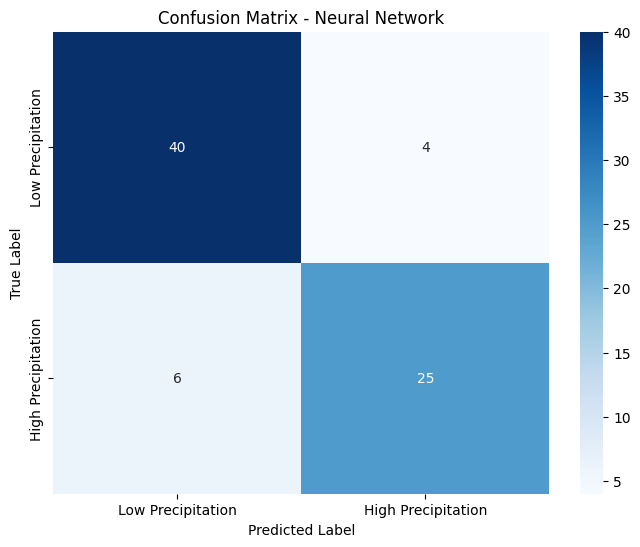

✅ Classification on SSL embeddings completed!


In [28]:
# Train classifiers on SSL embeddings
print("🎯 Training classifiers on SSL embeddings...")

# 1. Random Forest Classifier
print("   - Training Random Forest...")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
rf_pred = rf_classifier.predict(X_test)
rf_accuracy = (rf_pred == y_test).mean()

# 2. Logistic Regression
print("   - Training Logistic Regression...")
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)
lr_classifier.fit(X_train, y_train)
lr_pred = lr_classifier.predict(X_test)
lr_accuracy = (lr_pred == y_test).mean()

# 3. Neural Network Classifier
print("   - Training Neural Network...")
nn_classifier = EmbeddingClassifier(embeddings.shape[1], 2).to(device)
nn_optimizer = torch.optim.Adam(nn_classifier.parameters(), lr=0.001)
nn_criterion = nn.CrossEntropyLoss()

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Train neural network
nn_classifier.train()
for epoch in range(100):
    nn_optimizer.zero_grad()
    outputs = nn_classifier(X_train_tensor)
    loss = nn_criterion(outputs, y_train_tensor)
    loss.backward()
    nn_optimizer.step()

# Evaluate neural network
nn_classifier.eval()
with torch.no_grad():
    nn_outputs = nn_classifier(X_test_tensor)
    nn_pred = torch.argmax(nn_outputs, dim=1).cpu().numpy()
nn_accuracy = (nn_pred == y_test).mean()

# Print results
print(f"\n📊 Classification Results:")
print(f"   - Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"   - Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"   - Neural Network Accuracy: {nn_accuracy:.4f}")

# Detailed classification report for best model
best_model = "Random Forest" if rf_accuracy >= max(lr_accuracy, nn_accuracy) else "Logistic Regression" if lr_accuracy >= nn_accuracy else "Neural Network"
best_pred = rf_pred if rf_accuracy >= max(lr_accuracy, nn_accuracy) else lr_pred if lr_accuracy >= nn_accuracy else nn_pred

print(f"\n🏆 Best Model: {best_model}")
print("\n📈 Detailed Classification Report:")
print(classification_report(y_test, best_pred, target_names=['Low Precipitation', 'High Precipitation']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low Precipitation', 'High Precipitation'],
            yticklabels=['Low Precipitation', 'High Precipitation'])
plt.title(f'Confusion Matrix - {best_model}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("✅ Classification on SSL embeddings completed!")

## 8. Clustering and Retrieval with SSL Embeddings

Now let's explore the learned embeddings through clustering and implement a retrieval system to find similar weather patterns.

### 🎯 Goals:
1. **Clustering**: Discover natural groups in the learned embedding space
2. **Retrieval**: Find similar weather patterns given a query
3. **Visualization**: Understand the embedding space structure


🎯 Performing clustering analysis on SSL embeddings...
   - Applying K-means clustering...
   - Cluster distribution: [ 4 56  7  8]

🔍 Cluster Analysis by Precipitation Level:
   - Cluster 0: 4 samples
     • Low precipitation: 0 (0.0%)
     • High precipitation: 0 (0.0%)
   - Cluster 1: 56 samples
     • Low precipitation: 0 (0.0%)
     • High precipitation: 0 (0.0%)
   - Cluster 2: 7 samples
     • Low precipitation: 0 (0.0%)
     • High precipitation: 0 (0.0%)
   - Cluster 3: 8 samples
     • Low precipitation: 0 (0.0%)
     • High precipitation: 0 (0.0%)

📊 Preparing visualization...
   - PCA explained variance: 0.723, 0.079
   - Total explained variance: 0.802


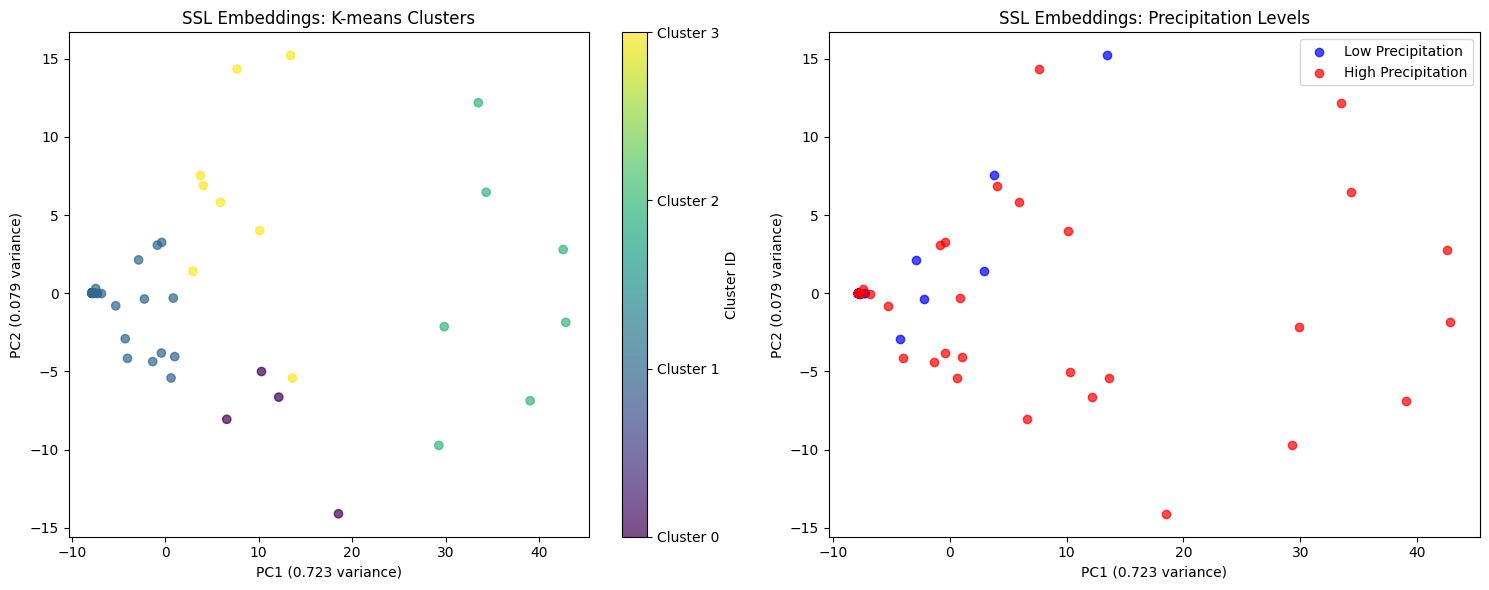

✅ Clustering analysis completed!


In [35]:
# Clustering analysis on SSL embeddings

print("🎯 Performing clustering analysis on SSL embeddings...")

# Prepare data for clustering
embeddings_np = X_test

# Apply K-means clustering
print("   - Applying K-means clustering...")
n_clusters = 4  # Try 4 weather pattern clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings_np)

# Calculate cluster statistics
cluster_counts = np.bincount(cluster_labels)
print(f"   - Cluster distribution: {cluster_counts}")

# Analyze clusters by precipitation labels
print("\n🔍 Cluster Analysis by Precipitation Level:")
for cluster_id in range(n_clusters):
    cluster_mask = cluster_labels == cluster_id
    cluster_precip_labels = embeddings_np[cluster_mask]
    low_precip_count = (cluster_precip_labels == 0).sum()
    high_precip_count = (cluster_precip_labels == 1).sum()
    
    print(f"   - Cluster {cluster_id}: {cluster_counts[cluster_id]} samples")
    print(f"     • Low precipitation: {low_precip_count} ({low_precip_count/cluster_counts[cluster_id]*100:.1f}%)")
    print(f"     • High precipitation: {high_precip_count} ({high_precip_count/cluster_counts[cluster_id]*100:.1f}%)")

# Reduce dimensionality for visualization
print("\n📊 Preparing visualization...")
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings_np)

explained_variance = pca.explained_variance_ratio_
print(f"   - PCA explained variance: {explained_variance[0]:.3f}, {explained_variance[1]:.3f}")
print(f"   - Total explained variance: {explained_variance.sum():.3f}")

# Plot clustering results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Clusters
ax1 = axes[0]
scatter = ax1.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                        c=cluster_labels, cmap='viridis', alpha=0.7)
ax1.set_title('SSL Embeddings: K-means Clusters')
ax1.set_xlabel(f'PC1 ({explained_variance[0]:.3f} variance)')
ax1.set_ylabel(f'PC2 ({explained_variance[1]:.3f} variance)')
cbar = plt.colorbar(scatter, ax=ax1, label='Cluster ID', ticks=range(n_clusters))
cbar.set_ticklabels([f'Cluster {i}' for i in range(n_clusters)])

# Plot 2: Precipitation levels
ax2 = axes[1]
colors = ['blue', 'red']
labels = ['Low Precipitation', 'High Precipitation']
for i, (color, label) in enumerate(zip(colors, labels)):
    mask = y_test == i
    ax2.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                c=color, alpha=0.7, label=label)
ax2.set_title('SSL Embeddings: Precipitation Levels')
ax2.set_xlabel(f'PC1 ({explained_variance[0]:.3f} variance)')
ax2.set_ylabel(f'PC2 ({explained_variance[1]:.3f} variance)')
ax2.legend()

plt.tight_layout()
plt.show()

print("✅ Clustering analysis completed!")

In [36]:
# 🎨 Understanding the Challenge: Why Self-Supervised Learning is Hard for Weather
print("\n🎨 Understanding the Challenge: Why Self-Supervised Learning is Hard for Weather")
print("="*70)

# Check if we have trained models available
if 'temporal_lightning_model' in locals() and 'masked_lightning_model' in locals():
    print("✅ Both models trained - let's understand the challenges they face...")
    
    # Analyze the inherent difficulties
    print("\n🤔 Why These Tasks Are Genuinely Difficult:")
    print("\n1️⃣ **Temporal Prediction Challenge:**")
    print("   🌧️ Weather is inherently chaotic - small changes can lead to big differences")
    print("   📊 Precipitation is highly non-linear and depends on many factors")
    print("   🗓️ 7 days of history often isn't enough to predict tomorrow's rain")
    print("   🌡️ Missing atmospheric conditions (temperature, pressure, humidity)")
    print("   💭 Think about it: Can you predict if it'll rain tomorrow just from")
    print("      looking at the past week's precipitation patterns?")
    
    print("\n2️⃣ **Masked Modeling Challenge:**")
    print("   ☁️ Weather systems are complex - rain doesn't follow simple spatial rules")
    print("   🎯 Guessing rainfall in the middle of a cloud is surprisingly hard!")
    print("   🌪️ Weather fronts and systems can have sharp boundaries")
    print("   📍 Local geography and orography affect precipitation patterns")
    print("   💭 Think about it: If you see rain around a region, how much rain")
    print("      should be in the center? It depends on so many factors!")
    
    print("\n🚀 Moving Forward - Better Approaches:")
    print("   • Include multiple weather variables (temperature, pressure, wind)")
    print("   • Use physics-informed neural networks")
    print("   • Incorporate atmospheric dynamics equations")
    print("   • Combine with traditional weather models")
    print("   • Use larger spatio-temporal windows and better spatial resolutions")
    
    print("\n💡 Key Takeaway:")
    print("   Self-supervised learning is powerful, but weather is complex!")
    print("   This workshop shows both the potential and the challenges.")
    print("   The 'failures' teach us as much as the successes! 🎓")
    
else:
    print("⚠️ Models not fully trained - run the training cells first!")
    print("   These examples show what you'll see after training.")

print("\n" + "="*50)
print("🎉 Workshop Complete - Great Learning Experience!")
print("="*50)



🎨 Understanding the Challenge: Why Self-Supervised Learning is Hard for Weather
✅ Both models trained - let's understand the challenges they face...

🤔 Why These Tasks Are Genuinely Difficult:

1️⃣ **Temporal Prediction Challenge:**
   🌧️ Weather is inherently chaotic - small changes can lead to big differences
   📊 Precipitation is highly non-linear and depends on many factors
   🗓️ 7 days of history often isn't enough to predict tomorrow's rain
   🌡️ Missing atmospheric conditions (temperature, pressure, humidity)
   💭 Think about it: Can you predict if it'll rain tomorrow just from
      looking at the past week's precipitation patterns?

2️⃣ **Masked Modeling Challenge:**
   ☁️ Weather systems are complex - rain doesn't follow simple spatial rules
   🎯 Guessing rainfall in the middle of a cloud is surprisingly hard!
   🌪️ Weather fronts and systems can have sharp boundaries
   📍 Local geography and orography affect precipitation patterns
   💭 Think about it: If you see rain around